In [2]:
from __future__ import print_function, division

In [3]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [5]:
import urllib2
import datetime

import numpy  as np

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn
from astropy import table

In [6]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [7]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl"


In [8]:
def catalog_to_sc(cat, hostordist = None):
    if hasattr(hostordist, 'dist'):
        distance = hostordist.dist
    else:
        distance = hostordist
        
    return SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg, distance=distance)

# Initial planning steps 

In [ ]:
#if online
ufo = urllib2.urlopen('https://docs.google.com/spreadsheet/ccc?key=1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8&output=csv')
hosttab = QTable.read(ufo.read(), format='csv')
ufo.close()

In [207]:
#if offline
hosttab = Table.read('SAGADropbox/hosts/host_catalog_flag0.csv')

In [62]:
hostscs = SkyCoord(u.Quantity(hosttab['RA'], u.deg), 
                   u.Quantity(hosttab['Dec'], u.deg), 
                   distance=u.Quantity(hosttab['distance'], u.Mpc))

In [57]:
#UTC time from 8:35-19:35 is AAT 18 deg window
nighttimes = Time('2015-6-20 8:35:00') + np.arange(12)*u.hour
aao = EarthLocation(lon='149:3:57.9', lat='-31:16:37.3')
aao_frame = AltAz(obstime=nighttimes, location=aao)

In [85]:
seczs = []
for sc in hostscs:
    az = sc.transform_to(aao_frame)
    seczs.append(az.secz)
seczs = np.array(seczs)

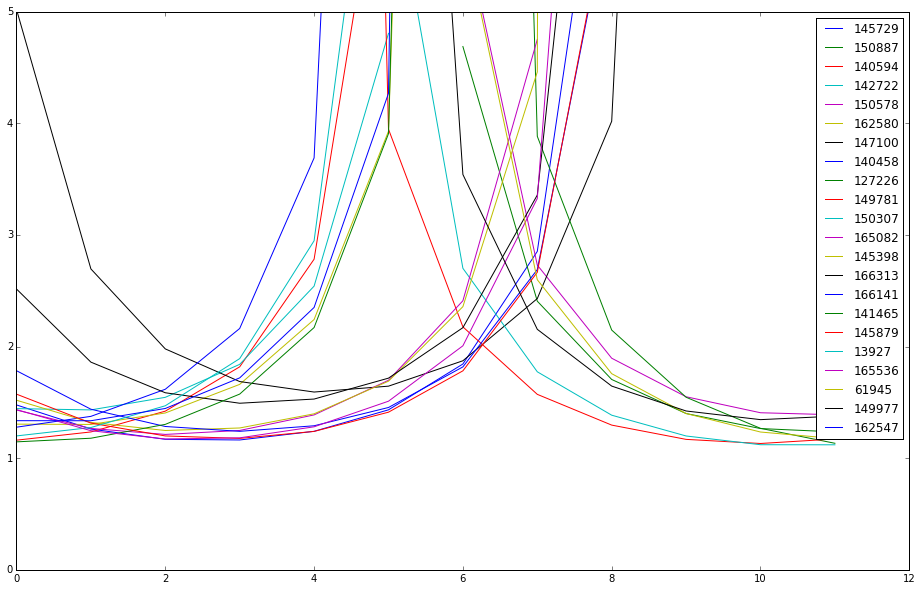

In [128]:
hrsvis = np.sum((1<=seczs)&(seczs<1.75),axis=1)

visenough = hrsvis>2
for secz, nsaid in zip(seczs[visenough], hosttab['NSAID'][visenough]):
    msk = secz>0
    plt.plot(np.arange(len(secz))[msk], secz[msk], label=nsaid)
plt.legend(loc=0)
plt.ylim(0,5)

In [137]:
names = []
ras = []

with open('aat_targets/aattargs_iobserve.dat', 'w') as f:
    for host in hosttab[visenough]:
        name = 'NSA'+str(host['NSAID'])
        for nm, val in hsd.items():
            if val.nsaid == host['NSAID']:
                name = nm
                if nm.startswith('NSA'):
                    name = name+'_obsed'
                break
        f.write(name.replace(' ','_') + ' ')
        f.write(str(host['RA']) + ' ')
        f.write(str(host['Dec']) + '\n')
        
        names.append(name)
        ras.append(host['RA'])
    
names = np.array(names)
ras = np.array(ras)
earlymsk = (10<ras/15)&(ras/15<18)
print('Early targets')
for nm in names[earlymsk]:
    print(nm)
    
print('\nLater targets')
for nm in names[~earlymsk]:
    print(nm)
    

Early targets
NSA145729
Alice in Wonderland
NSA142722
NSA162580
Odyssey
NSA140458
NSA165082
NSA145398
Gilgamesh
NSA166141
NSA141465
NSA145879
Sopronos
Dune
NSA162547

Later targets
NSA150887
NSA150578
NSA127226
NSA149781
NSA150307
Ana Karenina
NSA149977


# Targeting and master list design

Latest cuts:
```
rlim=20.5  or 21

   qsaga = where(sdss.r le rlim and sdss.rhost_kpc le 300 and
sdss.remove eq -1 and $
              sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err le 0.8 and $
              sdss.r-sdss.i-2*sdss.r_err-2*sdss.i_err le 0.5 and $
              sdss.r-sdss.K-2*sdss.r_err-2*sdss.Kerr le 2.0 and $
              sdss.r-sdss.W1-2*sdss.r_err-2*sdss.W1err le 2.6 and $
              sdss.u-sdss.g+2*sdss.u_err+2*sdss.g_err gt $
                         1.5*(sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err)-0.2 and $
              sdss.sb_exp_r ge 0.42*sdss.r+13.2 and $
              sdss.fibermag_r le 23,nsaga)


   qgri = where(sdss.r le rlim and sdss.rhost_kpc le 300 and $
              sdss.g-sdss.r-2*sdss.g_err-2*sdss.r_err le 0.8 and $
              sdss.r-sdss.i-2*sdss.r_err-2*sdss.i_err le 0.5 and $
              sdss.fibermag_r le 23,ngri)
```

Notes on allgoodspec fields:
```
    #      SATS = 3   if object is SAGA PRIMARY HOST
    #      SATS = 2   if object is low-z, z < 0.05
    #      SATS = 1   if object is SAGA SATELLITE (+/- 200 km/s w/in 300kpc)
    #      SATS = 0   if object is high-z, z > 0.05
    #      SATS = -1  no redshift


#  REMOVE =  -1 = GOOD OBJECT
#  REMOVE =   1 =  ON REMOVE LIST, DO NOT USE  (rm_removelist_obj)
#  REMOVE =   2 = SHREDDED OBJECT BASED ON NSA (nsa_cleanup)
# REMOVE =    3 = REPEATED SPECTRUM
```

In [9]:
dune = hsd['Dune']
ody = hsd['Odyssey']
gilg = hsd['Gilgamesh']
aen = hsd['Aeneid']
aen.environsarcmin = 30.
ob = hsd['OBrother']
anak = hsd['AnaK']
hostsforrun = [dune, ody, gilg, aen, ob, anak]

#*possible* target
n150307 = hosts.NSAHost(150307)

In [10]:
[(h.name, h.environskpc, h.environsarcmin) for h in hostsforrun]

[('Dune', 300.0, 41.056090595371984),
 ('Odyssey', 300.0, 30.327438140711887),
 ('Gilgamesh', 300.00000000000006, 37.18825214427636),
 ('Aeneid', 452.7927606385165, 30.0),
 ('OBrother', 300.0, 26.544825520097508),
 ('AnaK', 300.0, 29.934639294505377)]

In [11]:
#Casjobs queries.  But these don't have the UnWISE reduction, so we use different catalogs in the end
for h in hostsforrun:
    print(h.name, h.fnsdss)
    print(h.sdss_environs_query(dl=False, xmatchwise=True, usecas=True))
    print('\n\n')

Dune catalogs/Dune_sdss.dat

SELECT  p.objId  as objID,
p.ra, p.dec, p.type, p.flags, p.specObjID, dbo.fPhotoTypeN(p.type) as phot_sg,
p.modelMag_u as u, p.modelMag_g as g, p.modelMag_r as r,p.modelMag_i as i,p.modelMag_z as z,
p.modelMagErr_u as u_err, p.modelMagErr_g as g_err, p.modelMagErr_r as r_err,p.modelMagErr_i as i_err,p.modelMagErr_z as z_err,
p.psfMag_u as psf_u, p.psfMag_g as psf_g, p.psfMag_r as psf_r, p.psfMag_i as psf_i, p.psfMag_z as psf_z,
p.fibermag_r, p.fiber2mag_r,
p.petroMag_r + 2.5*log10(2*PI()*p.petroR50_r*p.petroR50_r) as sb_petro_r,
p.expMag_r, p.expMag_r + 2.5*log10(2*PI()*p.expRad_r*p.expRad_r + 1e-20) as sb_exp_r,
p.deVMag_r, p.deVMag_r + 2.5*log10(2*PI()*p.deVRad_r*p.deVRad_r + 1e-20) as sb_deV_r,
p.lnLExp_r, p.lnLDeV_r, p.lnLStar_r,
p.extinction_u as Au, p.extinction_g as Ag, p.extinction_r as Ar, p.extinction_i as Ai, p.extinction_z as Az,
ISNULL(s.z, -1) as spec_z, ISNULL(s.zErr, -1) as spec_z_err, ISNULL(s.zWarning, -1) as spec_z_warn, s.class as spec_c

In [12]:
# this actually sets up the hosts to use the UnWISE-matched catalogs
for h in hostsforrun:
    h.altfnsdss.insert(0, h.fnsdss)
    h.fnsdss = 'catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    print('Loading catalog for', h.name, 'from', h.fnsdss)
    h._cached_sdss = None  # make sure not to used an old cached one if its present
    c = h.get_sdss_catalog()
    #we have to modify these catalogs because 'phot_sg' in the fits catalogs are 3/6 instead of 'STAR'/'GALAXY', and 'type' is missing
    c.add_column(MaskedColumn(name='type', data=c['phot_sg']))
    c.remove_column('phot_sg')
    phot_sg = np.select([c['type']==3,c['type']==6], ['GALAXY','STAR']).astype('a6')
    c['phot_sg'] = MaskedColumn(name='phot_sg', data=phot_sg)

Loading catalog for Dune from catalogs/base_sql_nsa165536.fits.gz
Loading catalog for Odyssey from catalogs/base_sql_nsa147100.fits.gz
Loading catalog for Gilgamesh from catalogs/base_sql_nsa166313.fits.gz
Loading catalog for Aeneid from catalogs/base_sql_nsa148734.fits.gz
Loading catalog for OBrother from catalogs/base_sql_nsa149781.fits.gz
Loading catalog for AnaK from catalogs/base_sql_nsa61945.fits.gz


In [13]:
for h in hostsforrun:
    c = h.get_sdss_catalog()
    csc = SkyCoord(ra=c['ra']*u.deg, dec=c['dec']*u.deg, distance=h.dist)
    hsc = SkyCoord(h.coords, distance=h.dist)
    print(h.name,'max',np.max(csc.separation_3d(hsc).to(u.kpc)))

Dune max 438.568485555 kpc
Odyssey max 593.673251912 kpc
Gilgamesh max 484.017895385 kpc
Aeneid max 905.568740605 kpc
OBrother max 678.186424926 kpc
AnaK max 601.324486953 kpc


In [14]:
gricolorcuts = {'g-r': (None, 0.8, 2),
                'r-i': (None, 0.5, 2)}
sagacolorcuts = gricolorcuts.copy()
sagacolorcuts['r-K'] = (None, 2.0, 2)
sagacolorcuts['r-w1'] = (None, 2.6, 2)

def uggrline_cut(cat, sl=1.5, inter=-0.2):
    gt = cat['u']-cat['g']+2*(cat['u_err']+cat['g_err'])
    lt = sl*(cat['g']-cat['r']-2*(cat['g_err']+cat['r_err'])) + inter
    return gt > lt
gricolorcuts['funcs'] = sagacolorcuts['funcs'] = [uggrline_cut]

In [15]:
allgoodspec = Table(fits.getdata('allgoodspec_v2_jun14_15.fits.gz'))
allgoodspecnorem = allgoodspec[allgoodspec['REMOVE']==-1]

## Test round with Ody

In [266]:
allgoododydist = catalog_to_sc(allgoodspec, ody)

In [502]:
targs = targeting.select_targets(ody, colorcuts=sagacolorcuts, outercutrad=None, 
                                 galvsallcutoff=21, faintlimit=21, verbose=True,
                                 removespecstars=False, removegalsathighz =False) #do these because the fits catalogs don't have spec_class
len(targs)

Function 0 removed 3536 objects
Colorcut for g-r removed 30879 objects
Colorcut for r-K removed 5293 objects
Colorcut for r-i removed 30185 objects
Colorcut for r-w1 removed 57392 objects


1671

In [315]:
targsc = catalog_to_sc(targs, ody)
idx, d2d, d3d = targsc.match_to_catalog_sky(allgoododydist)
alreadytargeted = d2d < 1*u.arcsec
np.sum(alreadytargeted), np.sum(~alreadytargeted)

(332, 1339)

In [99]:
guides = aat.select_guide_stars_sdss(ody.get_sdss_catalog())
calibs = aat.select_flux_stars(ody.get_sdss_catalog(), onlyoutside=300*u.kpc)
skyradec = aat.select_sky_positions(ody)
aat.produce_master_fld(ody, datetime.date(2014, 6, 19), targs[~alreadytargeted], pris=None,
                       guidestars=guides, fluxstars=calibs,skyradec=skyradec,
                       outfn='aat_targets_jun2015/Odyssey_master_test.fld', randomizeorder=True)

['LABEL Odyssey base catalog',
 'UTDATE  2014 06 19',
 u'CENTRE  16 32 20.95 +19 49 35.15',
 'EQUINOX J2000.0',
 '# End of Header',
 '',
 '# TargetName(unique for header) RA(h m s) Dec(d m s) TargetType(Program,Fiducial,Sky) Priority(9 is highest) Magnitude 0 TargetName',
 u'Odyssey 16 32 20.95 +19 49 35.15 P 9 12.15 0 host galaxy',
 u'1237662224092562213 16 33 24.33 +19 47 16.18 P 5 21.72 0 magcol=fiber2mag_r, model_r=20.89',
 u'1237662698115498710 16 32 47.82 +19 40 26.22 P 7 21.05 0 magcol=fiber2mag_r, model_r=20.23',
 u'1237662224092496801 16 32 55.93 +19 54 37.79 P 5 21.73 0 magcol=fiber2mag_r, model_r=20.89',
 u'1237662224092431082 16 32 30.37 +19 55 55.57 P 7 21.23 0 magcol=fiber2mag_r, model_r=20.42',
 u'1237662223555429474 16 30 16.70 +19 45 03.80 P 5 21.83 0 magcol=fiber2mag_r, model_r=21.00',
 u'1237662698115236834 16 30 52.38 +20 00 39.72 P 5 21.55 0 magcol=fiber2mag_r, model_r=20.71',
 u'1237662698115433118 16 32 33.99 +19 42 15.97 P 7 20.90 0 magcol=fiber2mag_r, model_r=2

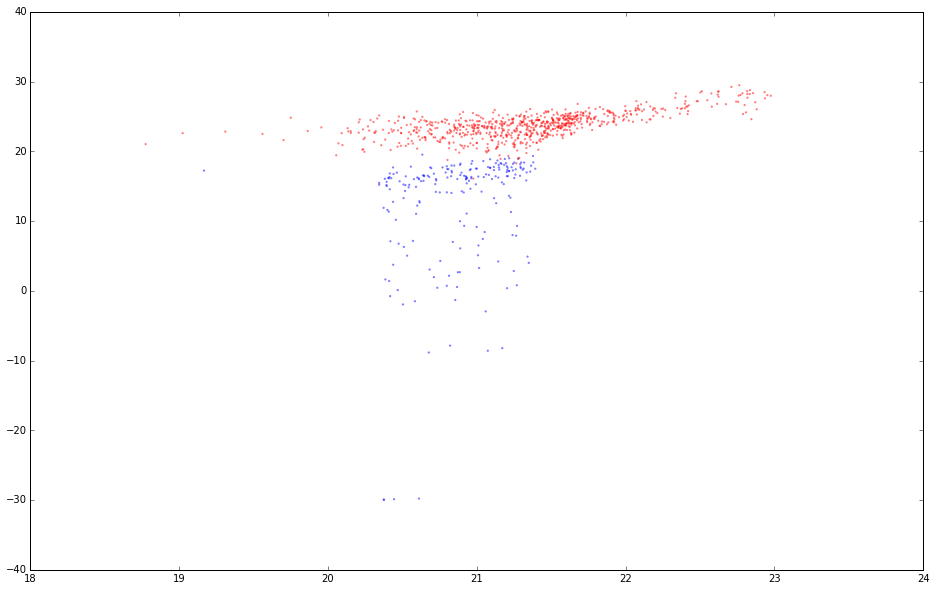

In [143]:
s = targs['phot_sg']=='STAR'
g = targs['phot_sg']=='GALAXY'
plt.scatter(targs['fibermag_r'][s],targs['sb_deV_r'][s],alpha=.5,s=5,edgecolor='none', facecolor='b')
plt.scatter(targs['fibermag_r'][g],targs['sb_deV_r'][g],alpha=.5,s=5,edgecolor='none', facecolor='r')

(20, 30)

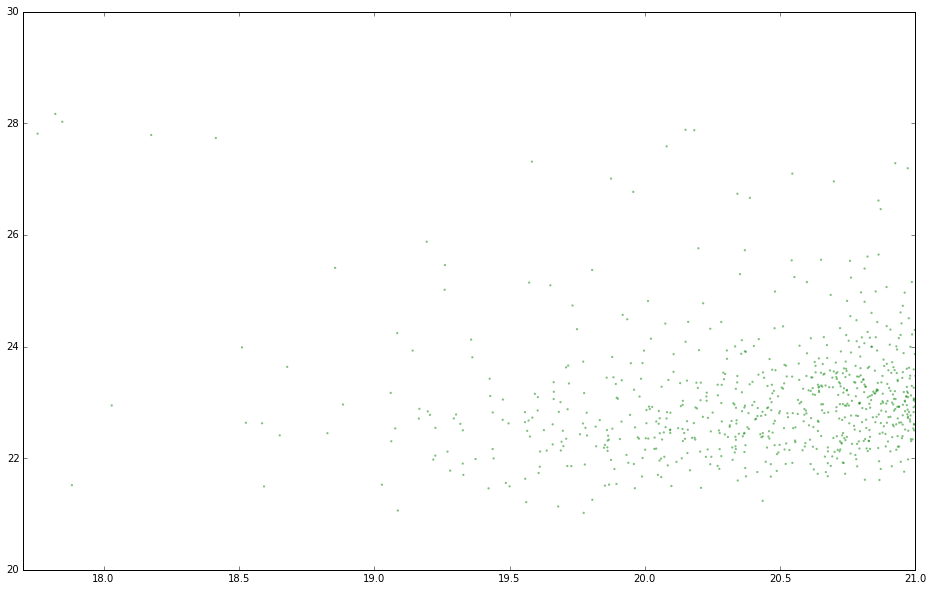

In [150]:
#plt.scatter(targs['r'],targs['sb_exp_r'],alpha=.5,s=5,edgecolor='none', facecolor='b')
#plt.scatter(targs['r'],targs['sb_deV_r'],alpha=.5,s=5,edgecolor='none', facecolor='r')
plt.scatter(targs['r'],targs['sb_petro_r'],alpha=.5,s=5,edgecolor='none', facecolor='g')
plt.xlim(17.7, 21)
plt.ylim(20,30)

##  Sky Fiber positions

For some hosts we already have sky positions from the last run, so copy those over

In [342]:
!cp aat_targets_jul2014/Gilgamesh_sky.dat aat_targets_jun2015/Gilgamesh_sky.dat
!cp aat_targets_jul2014/Aeneid_sky.dat aat_targets_jun2015/Aeneid_sky.dat
!cp aat_targets_jul2014/Ana_Karenina_sky.dat aat_targets_jun2015/AnaK_sky.dat

For the remainder, generate and visually inspect them one at a time. Edit the file to remove any that are not good sky positions

In [863]:
#Identify sky regions for each host and write out to separate files - 
from os.path import exists

for h in hostsforrun:
    outfn = 'aat_targets_jun2015/' + h.name.replace(' ','_') + '_sky.dat'
    if exists(outfn):
        print(outfn, 'exists, not overwriting')
    else:
        print('Writing', outfn)
        aat.select_sky_positions(h, nsky=100, outfn=outfn, rad=1*u.deg)

Writing aat_targets_jun2015/Dune_sky.dat
Writing aat_targets_jun2015/Odyssey_sky.dat
aat_targets_jun2015/Gilgamesh_sky.dat exists, not overwriting
aat_targets_jun2015/Aeneid_sky.dat exists, not overwriting
Writing aat_targets_jun2015/OBrother_sky.dat
aat_targets_jun2015/AnaK_sky.dat exists, not overwriting


In [865]:
aat.imagelist_fld_targets("aat_targets_jun2015/Dune_sky.dat", ttype='sky', n=np.inf);
!subl "aat_targets_jun2015/Dune_sky.dat"

In [866]:
aat.imagelist_fld_targets("aat_targets_jun2015/Odyssey_sky.dat", ttype='sky', n=np.inf);
!subl "aat_targets_jun2015/Odyssey_sky.dat"

In [867]:
aat.imagelist_fld_targets("aat_targets_jun2015/OBrother_sky.dat", ttype='sky', n=np.inf);
!subl "aat_targets_jun2015/OBrother_sky.dat"

## Make all the master catalogs

In [16]:
#now organize the targets that should be manually forced to priority-9 no matter what
#these are Dune targets that look especially promising
dune9="""
221.04498      0.18304042
221.07614     0.034178416
"""

#and these are OBrother
ob9="""
334.99197      -3.0978879
336.67442      -3.0774462
335.36295      -4.1283350
335.97998      -3.2705486
"""

#this is the ambiguous one in Odyssey
ody9='\n247.82589 20.210879'

ras = []
decs = []
for l in (dune9+ob9+ody9).split('\n'):
    if l.strip() == '':
        continue
    ra, dec = l.strip().split()
    ras.append(float(ra))
    decs.append(float(dec))
    
toforcemanual = SkyCoord(ras*u.deg, decs*u.deg)

In [178]:
#use this to manually add particular lines to the target catalog.  Here we just add the DECALS AnaK object
manualtargetlinesdct = {'AnaK':['DECALS_target_1     23 37 07.90 +0 12 40.86 P 8 21.33 0 magcol=decals_fiber2mag_r, decals_r=18.5']} 

In [17]:
# load the machine learning probabilities - these are used for pri 7 and 8
machine_learning_probs = Table.read('catalogs/machine_learning_june2015.csv.gz', format='csv')

In [19]:
for h in hostsforrun:
    print('Doing', h.name)
    
    allgooddist = catalog_to_sc(allgoodspec, h)
    targs = targeting.select_targets(h, colorcuts=gricolorcuts, outercutrad=None,
                                     galvsallcutoff=21, faintlimit=21.,
                                     removespecstars=False, removegalsathighz=False) #do these because the fits catalogs don't have spec_class
    targs = targeting.remove_targets_with_remlist(targs, h, 'TargetRemoveJun14_2015.csv')
    print('removing', np.sum(targs['REMOVE']!=-1),'REMOVE!=-1 objects')
    targs = targs[targs['REMOVE']==-1]

    targsc = catalog_to_sc(targs, h)
    idx, d2d, d3d = targsc.match_to_catalog_sky(allgooddist)
    alreadytargeted = d2d < 1*u.arcsec
    print('Already targeted', np.sum(alreadytargeted), 'leaving', np.sum(~alreadytargeted),'to target')
    
    #the targeting catalog *without* cuts applied, but de-duplicated
    rawdups = targeting.find_duplicate_objids(h.get_sdss_catalog())
    rawcatnodups = h.get_sdss_catalog()[~rawdups]
    print('Raw catalog has', np.sum(rawdups), 'duplicates')
    
    #for guide and flux, though, we need to use the *other* catalog, because the UnWISE matched one has a bright cut
    casjobs_cat = h._load_and_reprocess_sdss_catalog(h.altfnsdss[0])
    casjobs_cat = casjobs_cat[~targeting.find_duplicate_objids(casjobs_cat)]
    guides = aat.select_guide_stars_sdss(casjobs_cat)
    calibs = aat.select_flux_stars(casjobs_cat, onlyoutside=300*u.kpc)
    #skyradec = aat.select_sky_positions(h)
    skyradec = 'aat_targets_jun2015/{0}_sky.dat'.format(h.name)  # generated above
    
    targcat = targs[~alreadytargeted]
    #now look for duplicates and always take the first - usually means multiple WISE or 2MASS matches
    targdups = targeting.find_duplicate_objids(targcat)
    targcat = targcat[~targdups]
    print('Raw catalog has', np.sum(targdups), 'duplicates')
    
    #add column for extra notes
    #targcat.add_column(table.Column(name='extra_aat_notes', data=np.zeros(len(targcat), dtype='S25')))
    
    pris = aat.prioritize_targets(targcat, scheme='jun2015baseline')
    # these scheme doesn't include the SAGA color cuts yet - it just makes 1/2 and 3/4 on SB (1/2 is outside rvir)
    sagacolormsk = targeting.colorcut_mask(targcat, sagacolorcuts)
    #if you meet the saga cuts *and* are within rvir you get a boost to 5/6
    msk56 = sagacolormsk&(pris<5)&(pris>2)
    pris[msk56] += 2
    
    #now we set everything 
    
    #if you fail the saga cuts and are outside rvir you get thrown out... 
    #BUT WE DECIDED NOT TO DO THAT: the r-w1 cut seems to kick out things that we might want
    #outsidemsk = (~sagacolormsk)&(pris<3)
    #pris[outsidemsk] = 0
    
    # now the machine-learning forced priority 7/8 targets
    # everything with p_class1 > 0.05 goes into 7, and the 50 highest go into 8. Make those masks
    this_mlcat = machine_learning_probs[machine_learning_probs['HOST_NSAID']==h.nsaid]
    this_mlcat_scs = SkyCoord(this_mlcat['RA']*u.deg, this_mlcat['DEC']*u.deg)
    this_mlcat_withinrv = this_mlcat_scs.separation(h.coords) < h.environsarcmin*u.arcmin
    pri7_ml_msk = (this_mlcat['PROBABILITY_CLASS_1']>0.05)&this_mlcat_withinrv
    pri2_ml_msk = (this_mlcat['PROBABILITY_CLASS_1']>0.05)&~this_mlcat_withinrv
    pri8_ml_idx = np.argsort(this_mlcat['PROBABILITY_CLASS_1'])
    pri8_ml_idx = pri8_ml_idx[this_mlcat_withinrv[pri8_ml_idx]][-50:]
    #if they are in 8, don't put them in 2 or 7
    pri7_ml_msk[pri8_ml_idx] = False
    pri2_ml_msk[pri8_ml_idx] = False
    # now actually build the coordinate objects and match them to the base catalog
    targcat, pris = targeting.add_forced_targets(rawcatnodups, targcat, pris, this_mlcat['OBJID'][pri7_ml_msk], 7)
    targcat, pris = targeting.add_forced_targets(rawcatnodups, targcat, pris, this_mlcat['OBJID'][pri8_ml_idx], 8)
    pris2 = pris==2
    pris[pris2] = 1  # instead of 1/2 on SB, it's 2 for those with high ML-prob, and 1 for all else
    targcat, pris = targeting.add_forced_targets(rawcatnodups, targcat, pris, this_mlcat['OBJID'][pri2_ml_msk], 2)
    
    #and also set priorities for targets that by-hand should be forced to 8
    targcat, pris = targeting.add_forced_targets(rawcatnodups, targcat, pris, toforcemanual, 8)
    
    aat.produce_master_fld(h, datetime.date(2014, 6, 19), targcat, pris=pris, fluxpri=9,
                           guidestars=guides, fluxstars=calibs,skyradec=skyradec,
                           outfn='aat_targets_jun2015/{0}_master.fld'.format(h.name), 
                           randomizeorder=True, manualtargetlines=manualtargetlinesdct.get(h.name, []))
    print('') #newline

Doing Dune
Found host Dune in GAMA!
Removing 934 GAMA objects
Could not find a match for objid 1237648703519981589 of Dune, closest is [ 17.38537812] arcsec
Could not find a match for objid 1237648703519981597 of Dune, closest is [ 3.98125226] arcsec
Could not find a match for objid 1237648720712237216 of Dune, closest is [ 89.2805649] arcsec
Could not find a match for objid 1237648704593592350 of Dune, closest is [ 2.00734335] arcsec
Removed 6 objects for Dune
removing 23 REMOVE!=-1 objects
Already targeted 1036 leaving 2532 to target
Raw catalog has 13 duplicates
Raw catalog has 0 duplicates
Found 61 objID matches in list of things to force
Removed 5 Forced doubles (things that were already possible targets *and* forced)
Found 50 objID matches in list of things to force
Removed 4 Forced doubles (things that were already possible targets *and* forced)
Found 114 objID matches in list of things to force
Removed 20 Forced doubles (things that were already possible targets *and* forced)
F

# Nightly configurations/etc

## Night 1 (Jun 19)

In [21]:
scptarget = 'visitor3@aatlxa:configure/'

In [691]:
#note that this was done with a *different* master catalog: it does not have priorty 2 from the ML learning (instead they are all in 7)
h = dune
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 19 guides, and 92 skies not included): {1: 925, 2: 912, 3: 246, 4: 221, 5: 89, 6: 127, 7: 175, 8: 50, 9: 1}
Dune_1.fld                                    100%  121KB 121.0KB/s   00:00    


In [860]:
h = ody
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included): {1: 2898, 2: 215, 3: 10, 4: 11, 5: 10, 6: 69, 7: 12, 8: 51, 9: 1}
Odyssey_1.fld                                 100%   57KB  57.0KB/s   00:00    


In [894]:
h = aen
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 88 skies not included): {1: 408, 2: 0, 3: 16, 4: 17, 5: 55, 6: 92, 7: 63, 8: 50, 9: 1}
Aeneid_1.fld                                  100%   50KB  49.9KB/s   00:00    


In [24]:
h = ob
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:150, 4:150, 5:200, 6:200, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 95 skies not included): {1: 3426, 2: 86, 3: 260, 4: 193, 5: 135, 6: 241, 7: 0, 8: 49, 9: 1}
OBrother_1.fld                                100%   92KB  92.1KB/s   00:00    


Night pretty much a total wash - got 30 min in on OBrother_1, but probably mostly useless

## Night 2 (Jun 20) 

In [21]:
scptarget = 'visitor3@aatlxa:configure/'

In [33]:
h = dune
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included): {1: 1827, 2: 114, 3: 245, 4: 221, 5: 86, 6: 124, 7: 61, 8: 50, 9: 1}
Dune_1.fld                                    100%  104KB 103.6KB/s   00:00    


In [159]:
h = dune
fnbase = 'aat_targets_jun2015/' + h.name

finum = 2
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]

!scp {scptarget}{h.name}*.lis aat_targets_jun2015/
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
!scp $fnconfig $scptarget

Dune_1.lis                                    100%   45KB  44.9KB/s   00:00    
Dune_2.lis                                    100%   45KB  44.9KB/s   00:00    
Found 355 objects to remove in aat_targets_jun2015/Dune_1.lis
Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included): {1: 1827, 2: 114, 3: 245, 4: 168, 5: 9, 6: 8, 7: 2, 8: 1, 9: 0}
Dune_2.fld                                    100%   72KB  72.4KB/s   00:00    


In [76]:
h = ody
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:300, 2:300, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 92 skies not included): {1: 2888, 2: 215, 3: 16, 4: 30, 5: 4, 6: 49, 7: 12, 8: 51, 9: 1}
Odyssey_1.fld                                 100%   67KB  67.0KB/s   00:00    


In [117]:
h = aen
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:300, 2:300, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 88 skies not included): {1: 2753, 2: 314, 3: 41, 4: 52, 5: 23, 6: 64, 7: 63, 8: 50, 9: 1}
Aeneid_1.fld                                  100%   85KB  85.0KB/s   00:00    


In [118]:
h = ob
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:300, 2:300, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 95 skies not included): {1: 3426, 2: 86, 3: 260, 4: 193, 5: 135, 6: 241, 7: 0, 8: 49, 9: 1}
OBrother_1.fld                                100%  118KB 118.0KB/s   00:00    


In [179]:
h = anak
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)

listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:300, 2:300, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 20),
                              fieldname=str(finum), listorem=listorem)
#now scp to the aat machines to design config
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 96 skies not included): {1: 3253, 2: 116, 3: 90, 4: 118, 5: 64, 6: 154, 7: 0, 8: 51, 9: 1}
AnaK_1.fld                                    100%   85KB  85.4KB/s   00:00    


## Night 3 (Jun 21) 

In [21]:
scptarget = 'visitor3@aatlxa:configure/'

In [160]:
h = dune
fnbase = 'aat_targets_jun2015/' + h.name

finum = 3
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]

!scp {scptarget}{h.name}*.lis aat_targets_jun2015/
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 21),
                              fieldname=str(finum), listorem=listorem)
!scp $fnconfig $scptarget

Dune_1.lis                                    100%   45KB  44.9KB/s   00:00    
Dune_2.lis                                    100%   45KB  44.9KB/s   00:00    
Found 355 objects to remove in aat_targets_jun2015/Dune_1.lis
Found 354 objects to remove in aat_targets_jun2015/Dune_2.lis
Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included): {1: 1825, 2: 94, 3: 88, 4: 11, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0}
Dune_3.fld                                    100%   41KB  41.5KB/s   00:00    


In [181]:
h = gilg
fnbase = 'aat_targets_jun2015/' + h.name

finum = 1
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)]

aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 21),
                              fieldname=str(finum), listorem=listorem)
!scp $fnconfig $scptarget

Total remaining in each priority (5 fluxes, 30 guides, and 98 skies not included): {1: 2061, 2: 138, 3: 24, 4: 66, 5: 5, 6: 77, 7: 47, 8: 50, 9: 1}
Gilgamesh_1.fld                               100%   61KB  61.1KB/s   00:00    


## Load autoz's from Marla's reduction to decide which ones to remove

In [219]:
h = aen
fnbase = 'aat_targets_jun2015/' + h.name

finum = 2
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = ['aat_targets_jun2015/Aeneid_1.lis']
zlogfns = ['aat_targets_jun2015/Aeneid_1.zlog']

aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 21),
                              fieldname=str(finum), listorem=listorem,
                              zlogfns=zlogfns)
!scp $fnconfig $scptarget

Skipped the following fibers due to low zqual: [1, 2, 4, 5, 6, 8, 11, 12, 13, 14, 19, 20, 23, 31, 36, 37, 38, 40, 41, 42, 45, 46, 48, 49, 52, 57, 58, 60, 63, 64, 66, 67, 68, 72, 73, 78, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 95, 97, 98, 101, 102, 103, 104, 107, 108, 110, 115, 118, 119, 122, 124, 130, 134, 139, 140, 142, 144, 145, 146, 147, 149, 153, 154, 156, 159, 162, 163, 169, 171, 172, 173, 174, 176, 177, 180, 185, 187, 188, 189, 190, 191, 194, 195, 201, 202, 205, 207, 209, 211, 215, 216, 221, 222, 224, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 240, 241, 247, 248, 251, 252, 256, 257, 259, 260, 261, 263, 265, 266, 267, 268, 270, 273, 274, 277, 278, 279, 282, 283, 284, 290, 292, 293, 294, 302, 304, 306, 307, 310, 314, 317, 318, 319, 320, 321, 322, 323, 328, 329, 331, 336, 340, 341, 344, 347, 348, 349, 352, 354, 357, 358, 359, 360, 364, 369, 370, 371, 373, 374, 376, 378, 379, 381, 383, 384, 385, 389, 391, 392, 395, 396, 397, 398, 399]
Found 159 objects to remove in aat

In [438]:
h = ob
fnbase = 'aat_targets_jun2015/' + h.name

finum = 2
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = ['aat_targets_jun2015/OBrother_1.lis']
zlogfns = ['aat_targets_jun2015/OBrother_1slow.zlog']

def zltabkeepfunc(entry):
    if entry['zqual']<3:
        return True
    elif entry['zqual']==3 and entry['z']<.02:
        return True
    return False

aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 21),
                              fieldname=str(finum), listorem=listorem,
                              zlogfns=zlogfns, zltabkeepfunc=zltabkeepfunc)
!scp $fnconfig $scptarget

Kept the following fibers in due to zltabkeepfunc: [7, 8, 10, 11, 12, 13, 16, 17, 19, 20, 23, 24, 25, 37, 44, 52, 53, 60, 62, 63, 72, 79, 81, 82, 85, 86, 94, 96, 98, 99, 102, 106, 107, 108, 110, 113, 118, 119, 120, 122, 127, 131, 134, 138, 139, 142, 152, 155, 158, 160, 169, 170, 172, 174, 175, 177, 178, 180, 182, 188, 190, 193, 194, 197, 199, 201, 203, 212, 216, 217, 218, 227, 228, 239, 240, 241, 245, 246, 248, 249, 252, 253, 255, 258, 266, 275, 283, 288, 289, 290, 291, 294, 295, 297, 301, 302, 303, 305, 307, 309, 311, 319, 320, 324, 326, 329, 330, 331, 332, 333, 346, 348, 349, 353, 356, 358, 359, 360, 363, 365, 366, 369, 370, 373, 378, 379, 382, 385, 386, 387, 388, 389, 394, 395, 396, 397]
Found 219 objects to remove in aat_targets_jun2015/OBrother_1.lis
Total remaining in each priority (5 fluxes, 30 guides, and 95 skies not included): {1: 3426, 2: 86, 3: 259, 4: 176, 5: 67, 6: 145, 7: 0, 8: 13, 9: 0}
OBrother_2.fld                                100%   90KB  89.9KB/s   00:00    


In [443]:
h = anak
fnbase = 'aat_targets_jun2015/' + h.name

finum = 2
fnmaster = fnbase + '_master.fld'
fnconfig = fnbase + '_{0}.fld'.format(finum)
listorem = ['aat_targets_jun2015/AnaK_1.lis']
zlogfns = ['aat_targets_jun2015/AnaK_1.zlog']

def zltabkeepfunc(entry):
    if entry['zqual']<3:
        return True
    elif entry['zqual']==3 and entry['z']<.02:
        return True
    return False

aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:200, 2:200, 3:300, 4:300, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              utcobsdate=datetime.date(2015, 6, 21),
                              fieldname=str(finum), listorem=listorem,
                              zlogfns=zlogfns, zltabkeepfunc=zltabkeepfunc)
!scp $fnconfig $scptarget

Kept the following fibers in due to zltabkeepfunc: [1, 2, 4, 9, 11, 12, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 73, 74, 75, 77, 78, 79, 80, 83, 84, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114, 117, 119, 120, 121, 122, 124, 125, 127, 128, 130, 131, 134, 135, 137, 142, 145, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 164, 165, 167, 169, 170, 171, 172, 173, 174, 176, 177, 184, 186, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 203, 204, 207, 209, 213, 214, 215, 216, 217, 221, 222, 225, 226, 228, 230, 231, 232, 234, 236, 237, 240, 241, 242, 243, 244, 246, 247, 249, 251, 252, 253, 255, 259, 265, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 299, 301, 302, 303, 304, 305, 308, 309, 311, 312, 31

## Examining targets

In [115]:
tab, sc, info = aat.load_lis_file('aat_targets_jun2015/Dune_2.lis')
print(info)

LABEL Dune 2
UTDATE 2015 06 20
CENTRE 14 46 11.130  -00 13 22.59
EQUINOX 2000.0
PROPER_MOTIONS


In [116]:
targeting.sampled_imagelist(sc[tab['codes'] == 'F'], None, names=tab[tab['codes'] == 'F']['fibnums'])

'name ra dec\n50 221.786833333 -0.250763888889\n100 221.499291667 -0.638013888889\n150 220.916125 -0.769791666667\n200 221.025791667 -0.123305555556\n250 221.371041667 0.0571527777778\n300 221.529666667 0.579811111111\n350 222.121625 0.351430555556\n400 221.995 -0.237725'

# Miscellaneous 

## experimentation with ML stuff
requires that the master-list prep be in place

In [695]:
h, h.ra, np.mean(targs['ra']), len(targcat), len(pris)

(<hosts.NSAHost object w/ name 'AnaK' AKA: ['NGC7716', 'NSA61945']>,
 354.13105403011235,
 354.1165307355015,
 3849,
 3849)

In [121]:
ml_probs = Table.read('catalogs/machine_learning_june2015.csv.gz', format='csv')
ml_probs

OBJID,RA,DEC,DERED_R,HOST_NSAID,HOST_SAGA_NAME,PROBABILITY_CLASS_1,BEST_GUESS_CLASS
int64,float64,float64,float64,int64,string72,float64,int64
1237663277925204111,354.19530129,0.623404150085,15.9147,61945,AnaK,0.996579788789,1
1237648721248845970,221.315874582,-0.159530792095,15.0073,165536,Dune,0.996377840975,1
1237665566078402826,233.786715266,16.8710451043,15.6201,166313,Gilgamesh,0.98105981917,1
1237648702983176377,221.584835212,-1.08275118047,16.1253,165536,Dune,0.952071687678,1
1237662698115432544,248.051339587,19.6957396993,16.6417,147100,Odyssey,0.913708567144,1
1237668367458697416,233.57500272,16.1723997442,17.3436,166313,Gilgamesh,0.902231518307,1
1237648720711712783,220.698695953,-0.498377007486,16.9863,165536,Dune,0.890465657544,1
1237648704593592352,221.044983596,0.183040423156,20.3064,165536,Dune,0.864805674055,1
1237665566078599491,234.269565649,16.861385789,17.7395,166313,Gilgamesh,0.852158358331,1


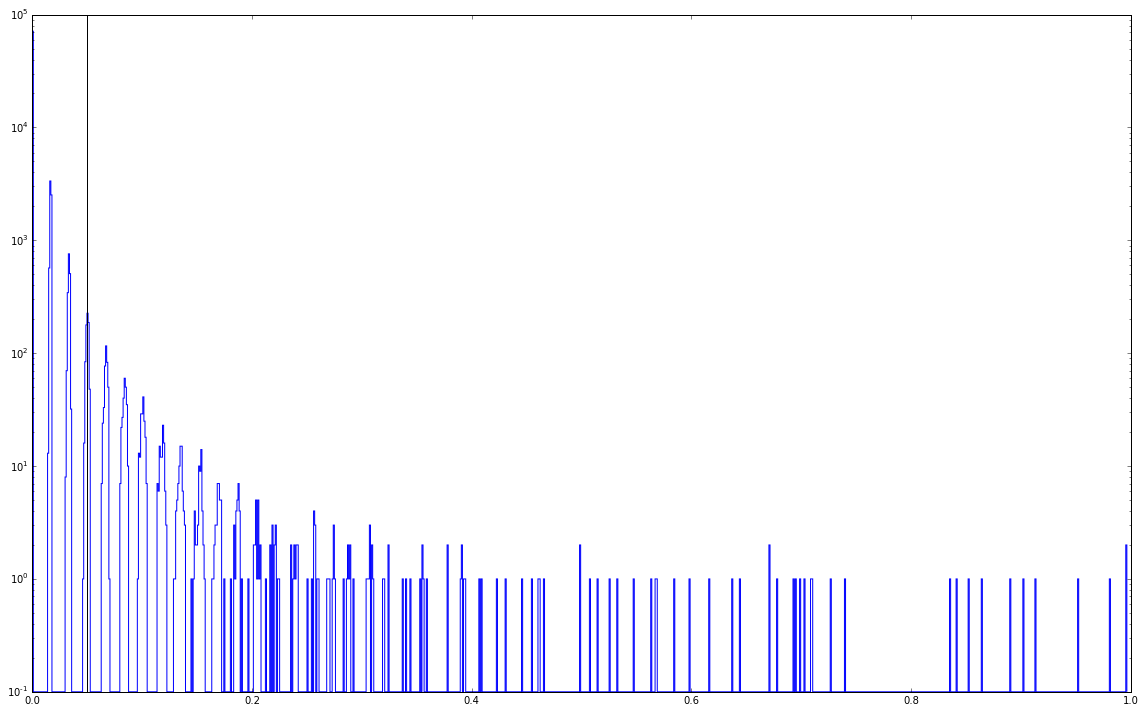

In [697]:
plt.hist(ml_probs['PROBABILITY_CLASS_1'], bins=1000,log=True,histtype='step')
plt.axvline(0.05, c='k')
plt.tight_layout()

In [698]:
this_mlcat = ml_probs[ml_probs['HOST_NSAID']==h.nsaid]
len(this_mlcat)

7322

In [699]:
np.sum(np.in1d(targcat['objID'], this_mlcat['OBJID'])), len(targcat)

(866, 3849)

In [700]:
np.sum(np.in1d(targcat['objID'][pris>2], this_mlcat['OBJID'])), np.sum(pris>2)

(221, 590)

In [701]:
np.sum(this_mlcat['PROBABILITY_CLASS_1']>0.05), len(this_mlcat)

(164, 7322)

In [702]:
#now check that they're all at least in the base catalog
rawcat = h.get_sdss_catalog()
np.sum(np.in1d(this_mlcat['OBJID'], rawcat['objID'])), len(this_mlcat)

(7322, 7322)

In [703]:
this_mlcat['PROBABILITY_CLASS_1'][np.argsort(this_mlcat['PROBABILITY_CLASS_1'])[-50:]]

0.10072598065
0.100874380638
0.102701993496
0.102743960392
0.102798716401
0.103814898732
0.113723864084
0.113907976758
0.11525451039
0.116189603623
0.11619600644


In [763]:
ml_scs = SkyCoord(u.Quantity(ml_probs['RA'],u.deg),u.Quantity(ml_probs['DEC'],u.deg))
targeting.sampled_imagelist(ml_scs[ml_probs['PROBABILITY_CLASS_1']>.5], None, None);

In [764]:
ml_scs = SkyCoord(u.Quantity(ml_probs['RA'],u.deg),u.Quantity(ml_probs['DEC'],u.deg))
targeting.sampled_imagelist(ml_scs[ml_probs['PROBABILITY_CLASS_1']>.1], None, None);

#### Checks that the ML targets match coordinates w/objids

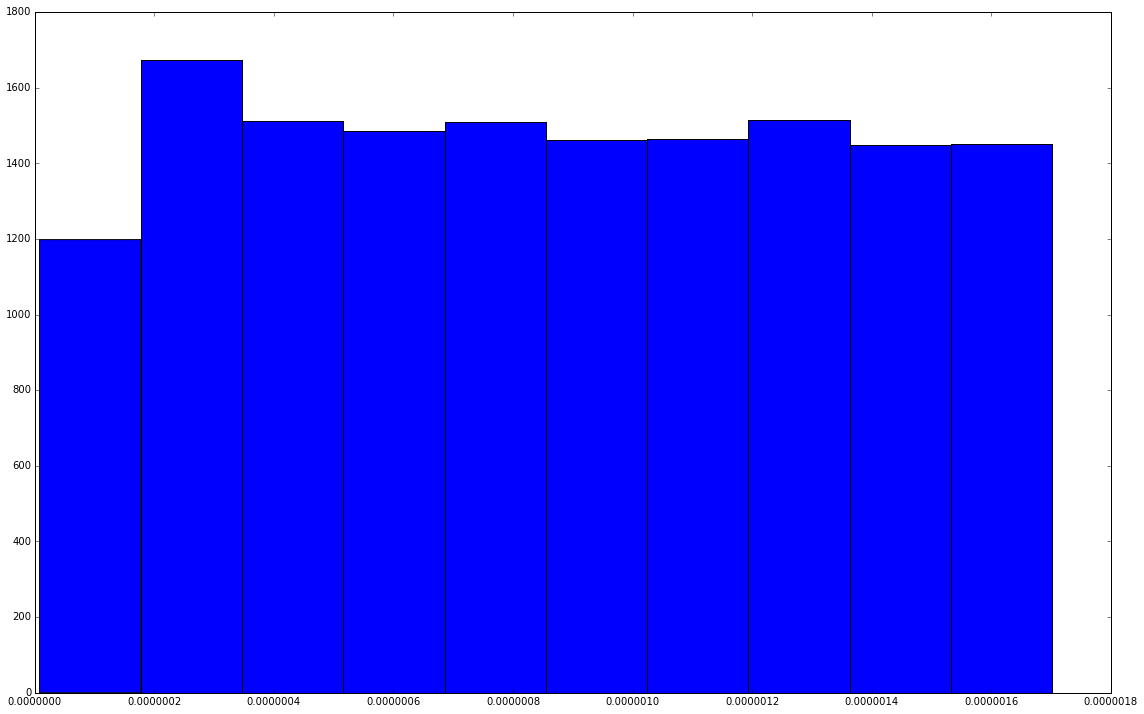

In [143]:
omlps = ml_probs[ml_probs['HOST_SAGA_NAME']=='Odyssey']
omlps['OBJID'].name = 'objID'
ocat = ody.get_sdss_catalog()
joined = table.join(ody.get_sdss_catalog(), omlps, keys='objID')
dra = joined['ra']-joined['RA']
ddec = joined['dec']-joined['DEC']
plt.hist(np.hypot(dra*np.cos(ody.coords.dec), ddec)*3600)
plt.tight_layout()

Looks like all is good - they match to ~microarcsec, which is probably rounding

In [150]:
# random sampling from the master list:
# 1237662697578561899 16 31 48.49 +19 28 27.25 P 8 20.14 0 magcol=fiber2mag_r, model_r=16.62r
match = omlps[omlps['objID']== 1237662697578561899 ]
SkyCoord(match['RA'], match['DEC'], unit=u.deg).to_string('hmsdms')

[u'16h31m48.4901s +19d28m27.2516s']

## Checks for bright stars in SDSS catalogs

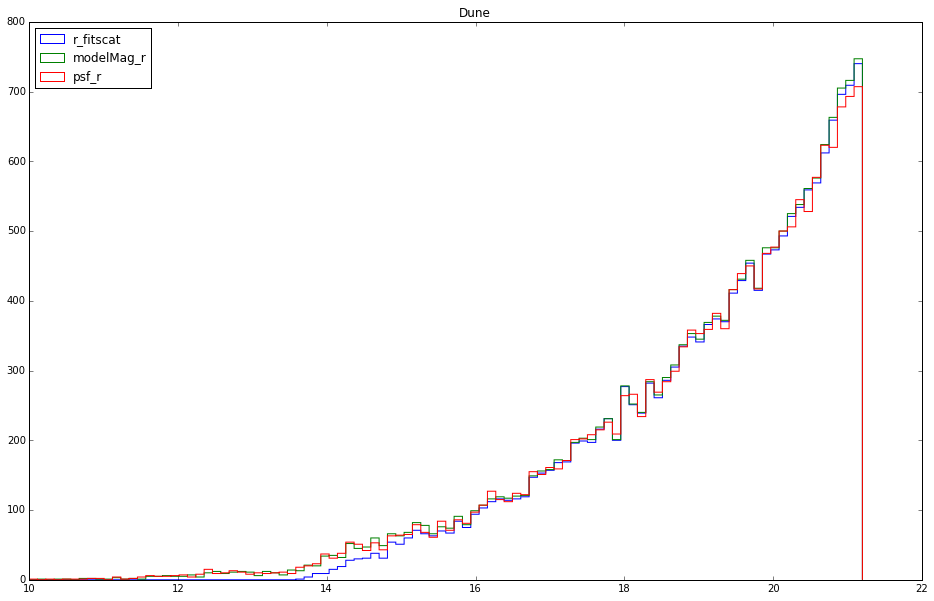

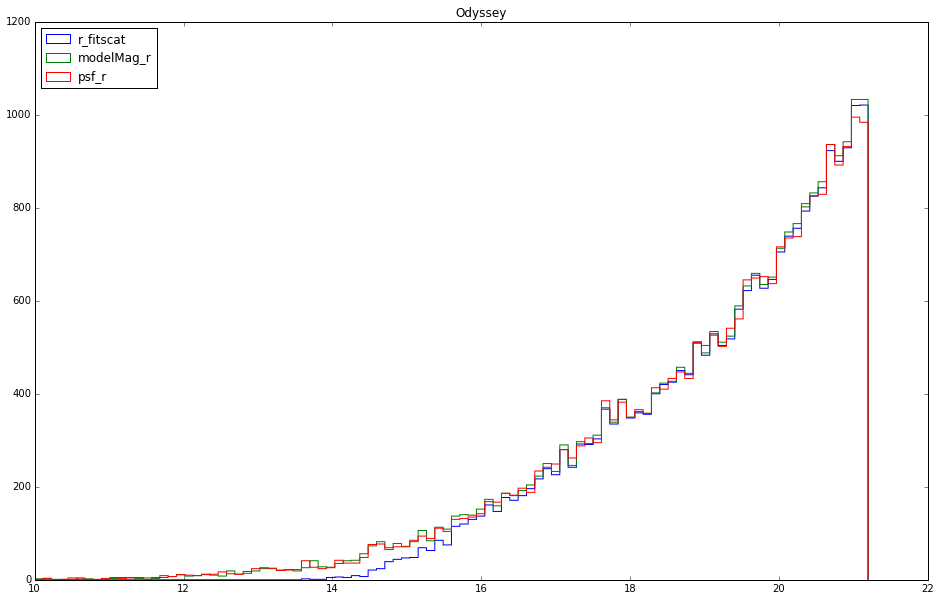

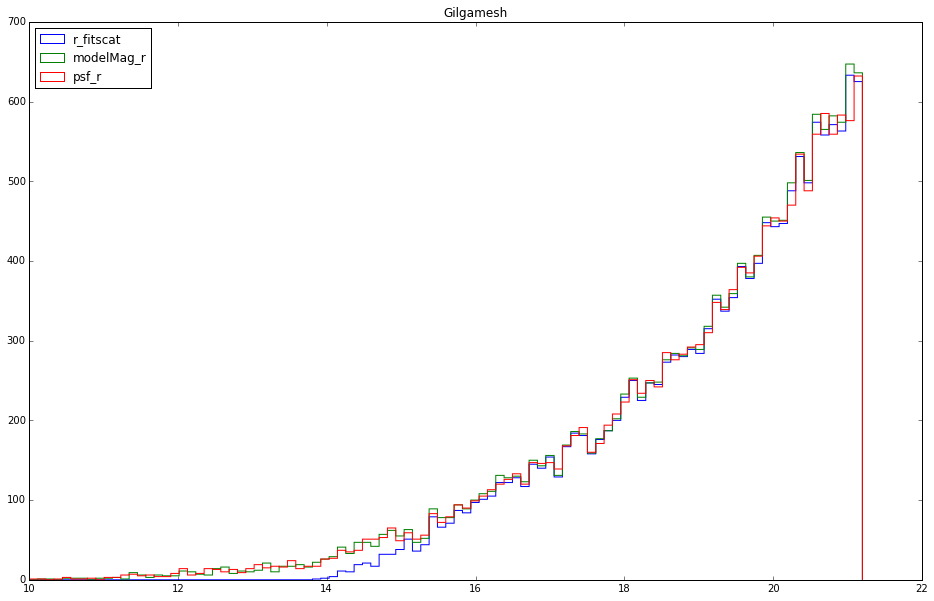

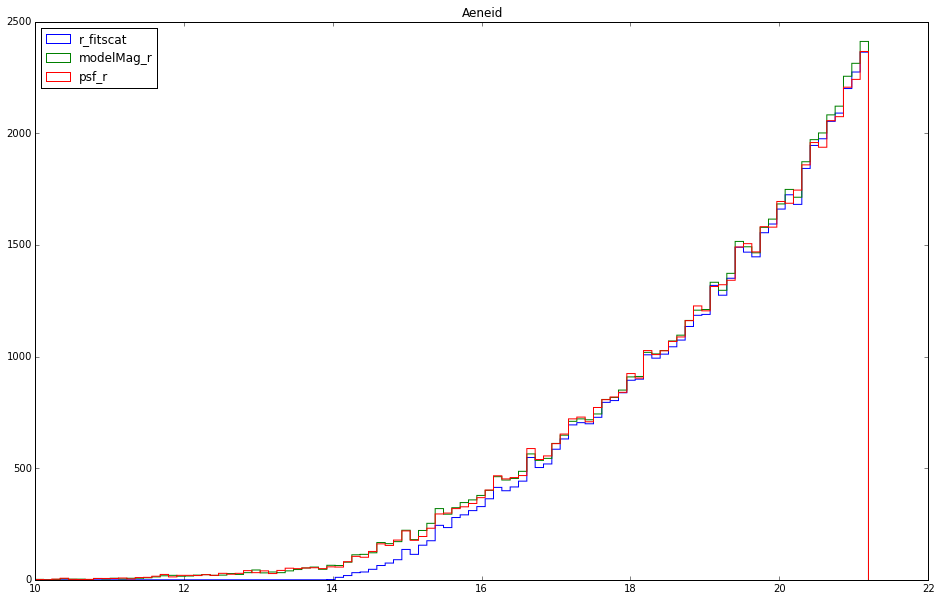

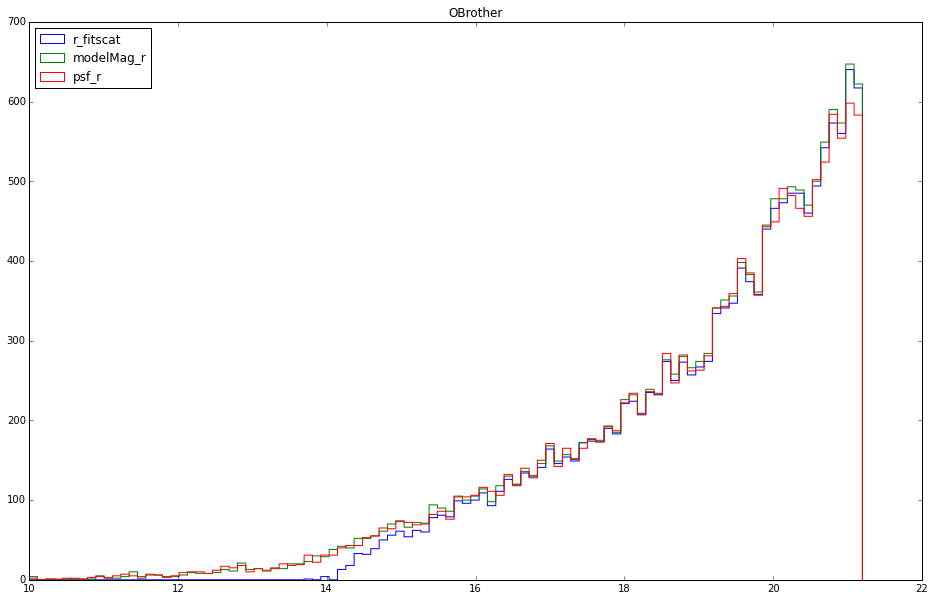

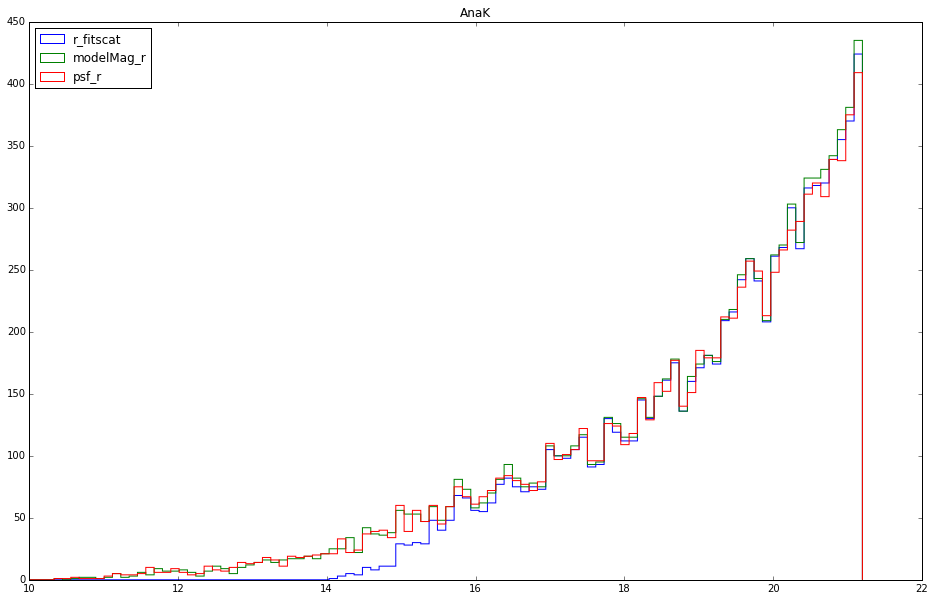

In [892]:
for h in hostsforrun:
    rawcat = fits.getdata(h.fnsdss)
    rawcat2 = Table.read(h.altfnsdss[0], format='csv', guess=False)
    stars = rawcat['phot_sg']==6
    stars2 = rawcat2['type']==6
    
    plt.figure()
    plt.hist(rawcat[stars]['r'],bins=100, range=(10,21.2), histtype='step', label='r_fitscat')
    plt.hist(rawcat2[stars2]['r'],bins=100, range=(10,21.2), histtype='step', label='modelMag_r')
    plt.hist(rawcat2[stars2]['psf_r'],bins=100, range=(10,21.2), histtype='step', label='psf_r')
    plt.title(h.name)
    plt.legend(loc='upper left')
    plt.savefig('/Users/erik/tmp/stars'+h.name+'.png')

### Investigate targets that get priority 8 but turn out to be stars

In [451]:
h = aen
zlfn = 'aat_targets_jun2015/Aeneid_1.zlog'
lisfn = 'aat_targets_jun2015/Aeneid_1.lis'

In [483]:
h = ob
zlfn = 'aat_targets_jun2015/OBrother_1slow.zlog'
lisfn = 'aat_targets_jun2015/OBrother_1.lis'

In [444]:
h = anak
zlfn = 'aat_targets_jun2015/AnaK_1.zlog'
lisfn = 'aat_targets_jun2015/AnaK_1.lis'

In [484]:
zltab = Table.read(zlfn, format='ascii', names=aat.zlogcolnames)
zltab

name,ra,dec,mag,z,sn,zqual,idx,sat?,star,unknown
string144,float64,float64,float64,float64,float64,int64,int64,int64,int64,string32
OBrother_1slow_002,336.196228027,-3.442491531,21.96,0.392299,6.298147,3,1,0,0,none
OBrother_1slow_003,336.333770752,-3.51373601,21.81,0.252784,13.29357,4,2,0,0,none
OBrother_1slow_004,336.216949463,-3.489738703,19.75,0.029733,14.629863,4,3,0,0,none
OBrother_1slow_005,336.340301514,-3.482774734,20.83,0.038745,13.679986,4,4,0,0,none
OBrother_1slow_006,336.31741333,-3.43503046,21.62,0.10548,9.385761,4,5,0,0,none
OBrother_1slow_007,336.059967041,-3.409421921,22.53,0.008336,6.152685,0,6,0,0,none
OBrother_1slow_008,336.265014648,-3.454447031,21.98,0.382301,4.232491,0,7,0,0,none
OBrother_1slow_009,336.127319336,-3.411916494,22.78,0.066502,10.580534,4,8,0,0,none
OBrother_1slow_010,336.006347656,-3.427905321,22.98,0.211224,4.527804,0,9,0,0,none


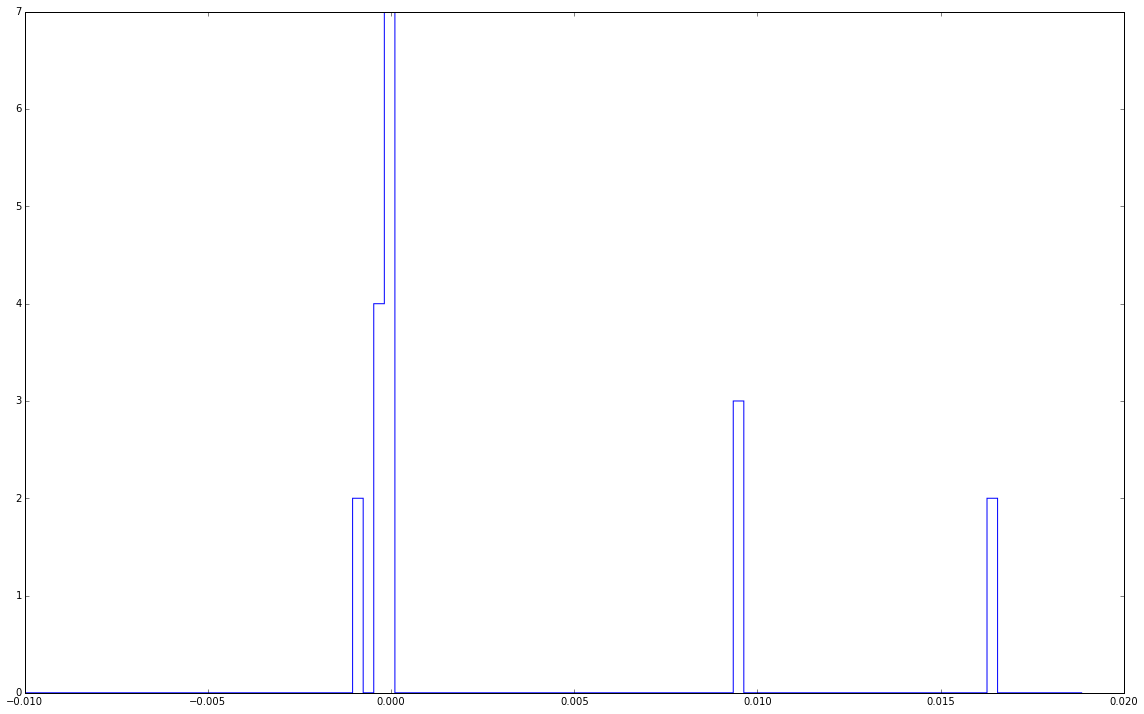

In [485]:
plt.hist(zltab[zltab['zqual']>2]['z'], bins=100, range=(-.01, h.zspec*2), histtype='step')
plt.tight_layout()

In [486]:
listab, lissc, lisinfo = aat.load_lis_file(lisfn)
listab

fibnums,ids,ras,decs,codes,pris,mags,comments
int64,string152,string96,string96,string8,int64,float64,string264
1,Sky29,22:25:37.960,-03:26:07.85,S,9,20.0,sky
2,1237679996084683619,22:24:47.100,-03:26:32.97,P,4,21.96,"magcol=fiber2mag_r, model_r=20.53"
3,1237680192048988574,22:25:20.110,-03:30:49.45,P,6,21.81,"magcol=fiber2mag_r, model_r=20.31"
4,1237680192048922851,22:24:52.070,-03:29:23.06,P,8,19.75,"magcol=fiber2mag_r, model_r=18.33"
5,1237680192048988479,22:25:21.680,-03:28:57.99,P,8,20.83,"magcol=fiber2mag_r, model_r=19.32"
6,1237679996084749076,22:25:16.180,-03:26:06.11,P,6,21.62,"magcol=fiber2mag_r, model_r=18.96"
7,1237679996084683389,22:24:14.400,-03:24:33.92,P,8,22.53,"magcol=fiber2mag_r, model_r=21.75"
8,1237680192048923276,22:25:03.610,-03:27:16.01,P,6,21.98,"magcol=fiber2mag_r, model_r=20.77"
9,1237679996084683480,22:24:30.560,-03:24:42.90,P,6,22.78,"magcol=fiber2mag_r, model_r=20.85"


In [487]:
fibnums = [int(nm.split('_')[-1]) if nm != 'noid' else -1 for nm in zltab['name']]
objids = []
matchpris = []
for fibnum in fibnums:
    if fibnum == -1:
        objids.append(-1)
        matchpris.append(-1)
    else:
        matchid = listab['ids'][fibnum==listab['fibnums']][0]
        if matchid.startswith('Flux') or matchid.startswith('DECALS'):
            objids.append(-2)
            matchpris.append(-2)
        elif matchid == h.name:
            objids.append(-3)
            matchpris.append(-3)
        else:
            objids.append(int(matchid))
            matchpris.append(listab['pris'][fibnum==listab['fibnums']][0])
            
cat = h.get_sdss_catalog()
sg = np.array([objid if objid < 0 else cat['phot_sg'][objid==cat['objID']][0]  for objid in objids])
matchpris = np.array(matchpris)

In [488]:
galwithlowz = (sg=='GALAXY')&(zltab['zqual']>2)&(np.abs(zltab['z'])<0.005)
starwithhighz = (sg=='STAR')&(zltab['zqual']>2)&(np.abs(zltab['z'])>0.005)

galwithhighz = (sg=='GALAXY')&(zltab['zqual']>2)&(np.abs(zltab['z'])>0.005)
starwithlowz = (sg=='STAR')&(zltab['zqual']>2)&(np.abs(zltab['z'])<0.005)

np.sum(galwithlowz), np.sum(starwithhighz), np.sum(galwithhighz), np.sum(starwithlowz)

(2, 4, 206, 6)

In [492]:
names = np.array(['{3}:{0}wpri{1}z={2:.2g}'.format(sgi, pi, zi, nmi.split('_')[-1]) for sgi, pi, zi, nmi in zip(sg, matchpris, zltab['z'], zltab['name'])])

#all things w/ stars
targeting.sampled_imagelist(zltab[sg=='STAR'], None, None, names=names[sg=='STAR'], posttoimglist=0.1)

#weird things
targeting.sampled_imagelist(zltab[galwithlowz], None, None, names=names[galwithlowz], posttoimglist=0.1)
targeting.sampled_imagelist(zltab[starwithhighz], None, None, names=names[starwithhighz], posttoimglist=0.1)

#expected things
targeting.sampled_imagelist(zltab[galwithhighz], None, None, names=names[galwithhighz], posttoimglist=0.1)
targeting.sampled_imagelist(zltab[starwithlowz], None, None, names=names[starwithlowz], posttoimglist=0.1)
h.zspec

0.0094332071

Inspection of results from above suggests that the Aeneid field has many more correctly-IDed stars, while for AnaK and OBrother, it's about even.

In [499]:
for h in hostsforrun:
    print(h.name, h.coords.galactic.b.deg)

Dune 51.1661152257
Odyssey 39.2084463832
Gilgamesh 50.4727808687
Aeneid -26.4283042102
OBrother -47.5016287092
AnaK -57.1915912554


Ah - it's probably because Aeneid is much closer to the galactic plane than the others, so just more stars period

### Stars in master catalogs

In [547]:
for h in hostsforrun:
    tab, sc, hdr = aat.load_fld('aat_targets_jun2015/{0}_master.fld'.format(h.name))
    
    objidtopri = {}
    for entry in tab:
        try:
            objid = int(entry['name'])
            objidtopri[objid] = entry['pri']
        except ValueError:
            pass
        
    
    cat = h.get_sdss_catalog()
    pris = np.array([objidtopri.get(i, -1) for i in cat['objID']])

    
    probmsk = (pris==2)|(pris==7)|(pris==8)
    starmsk = cat['phot_sg']=='STAR'
    
    print(h.name, np.sum(probmsk&starmsk), 'stars of', np.sum(probmsk))
    targeting.sampled_imagelist(cat[probmsk&starmsk], None, None, names=pris[probmsk&starmsk], posttoimglist=.1)
    
    

Dune 60 stars of 227
Odyssey 85 stars of 278
Gilgamesh 50 stars of 235
Aeneid 264 stars of 427
OBrother 31 stars of 138
AnaK 28 stars of 167


Visual inspection says that majority of these are stars but some are not and some are ambiguous